In [1]:
#import quandl
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)
import sklearn.datasets
import pandas as pd
from sklearn import preprocessing

backwards_points = 75

In [3]:
#DJIA_data = quandl.get("BCB/UDJIAD1", start_date="2001-12-31", end_date="2005-12-31")
DJIA_test_plot = pd.read_csv("upload_DJIA_table.csv")

In [4]:
#plot_test = pd.DataFrame(DJIA_data)
#DJIA_data = DJIA_data.reset_index()
DJIA_test_plot = DJIA_test_plot.sort_values(by="Date", ascending=True)
DJIA_test_plot["Time (Days)"] = np.arange(len(DJIA_test_plot))
DJIA_test_plot = DJIA_test_plot.drop("Date", axis = 1)
DJIA_test_plot.head()

,Open,High,Low,Close,Volume,Adj Close,Time (Days)
1988,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0
1987,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1
1986,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,2
1985,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,3
1984,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,4


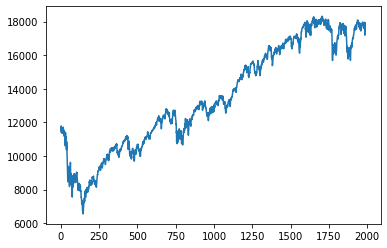

In [5]:
plt.plot(DJIA_test_plot["Time (Days)"], DJIA_test_plot["Open"], label='DJIA')

In [6]:
def to_dataset(your_set):
    DJIA_df = pd.read_csv("upload_DJIA_table.csv")
    DJIA_df = DJIA_df.sort_values(by="Date", ascending=True)
    DJIA_df = DJIA_df.drop("Date", axis = 1)
    DJIA_df = DJIA_df.values

    DJIA_df_normaliser = preprocessing.MinMaxScaler()
    DJIA_df_normalised = DJIA_df_normaliser.fit_transform(DJIA_df)
    past_values_normalised =  np.array([DJIA_df_normalised[i:i + backwards_points].copy() for i in range(len(DJIA_df_normalised) - backwards_points)])
    next_day_values_normalised =  np.array([DJIA_df_normalised[:,0][i + backwards_points].copy() for i in range(len(DJIA_df_normalised) - backwards_points)])
    next_day_values_normalised = np.expand_dims(next_day_values_normalised, -1)
    next_day_values = np.array([DJIA_df[:,0][i + backwards_points].copy() for i in range(len(DJIA_df) - backwards_points)])
    next_day_values = np.expand_dims(next_day_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_values)
    
    assert past_values_normalised.shape[0] == next_day_values_normalised.shape[0]
    return past_values_normalised, next_day_values_normalised, next_day_values, y_normaliser

In [7]:
past_values, next_day_values, unscaled_y, y_normaliser = to_dataset("upload_DJIA_table.csv")

test_split = 0.8
n = int(past_values.shape[0] * test_split)

X_train = past_values[:n]
y_train = next_day_values[:n]

X_test = past_values[n:]
y_test = next_day_values[n:]

unscaled_y_test = unscaled_y[n:]

print(X_train.shape)
print(X_test.shape)

(1531, 75, 6)
(383, 75, 6)


In [8]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers

#https://keras.io/api/layers/recurrent_layers/lstm/

lstm_input = Input(shape = (backwards_points, 6), name='lstm_input')
x = LSTM(75, name = "lstm_0")(lstm_input)
x = Dropout(0.21, name = "lstm_dropout_0")(x)
x = Dense(64, name = "dense_0")(x)
x = Activation("sigmoid", name = "sigmoid_0")(x)
x = Dense(1, name = "dense_1")(x)
output = Activation("linear", name = "linear_output")(x)

model = Model(inputs = lstm_input, outputs=output)
adam = optimizers.Adam(lr = 0.0005)
model.compile(optimizer = adam, loss="mse")
model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate(X_test, y_test)
print(evaluation)

Using TensorFlow backend.


Train on 1377 samples, validate on 154 samples
Epoch 1/50
1377/1377 [==============================] - 4s 3ms/step - loss: 0.3704 - val_loss: 0.0701
Epoch 2/50
1377/1377 [==============================] - 4s 3ms/step - loss: 0.0071 - val_loss: 0.0121
Epoch 3/50
1377/1377 [==============================] - 4s 3ms/step - loss: 0.0048 - val_loss: 0.0071
Epoch 4/50
1377/1377 [==============================] - 4s 3ms/step - loss: 0.0037 - val_loss: 0.0046
Epoch 5/50
1377/1377 [==============================] - 4s 3ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 6/50
1377/1377 [==============================] - 4s 3ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 7/50
1377/1377 [==============================] - 4s 3ms/step - loss: 0.0027 - val_loss: 7.6333e-04
Epoch 8/50
1377/1377 [==============================] - 4s 3ms/step - loss: 0.0027 - val_loss: 6.9573e-04
Epoch 9/50
1377/1377 [==============================] - 4s 3ms/step - loss: 0.0023 - val_loss: 6.1463e-04
Epoch 10/50
1377/1377 [

In [9]:
y_test_predicted = model.predict(X_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(past_values)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

1858.9093332176212


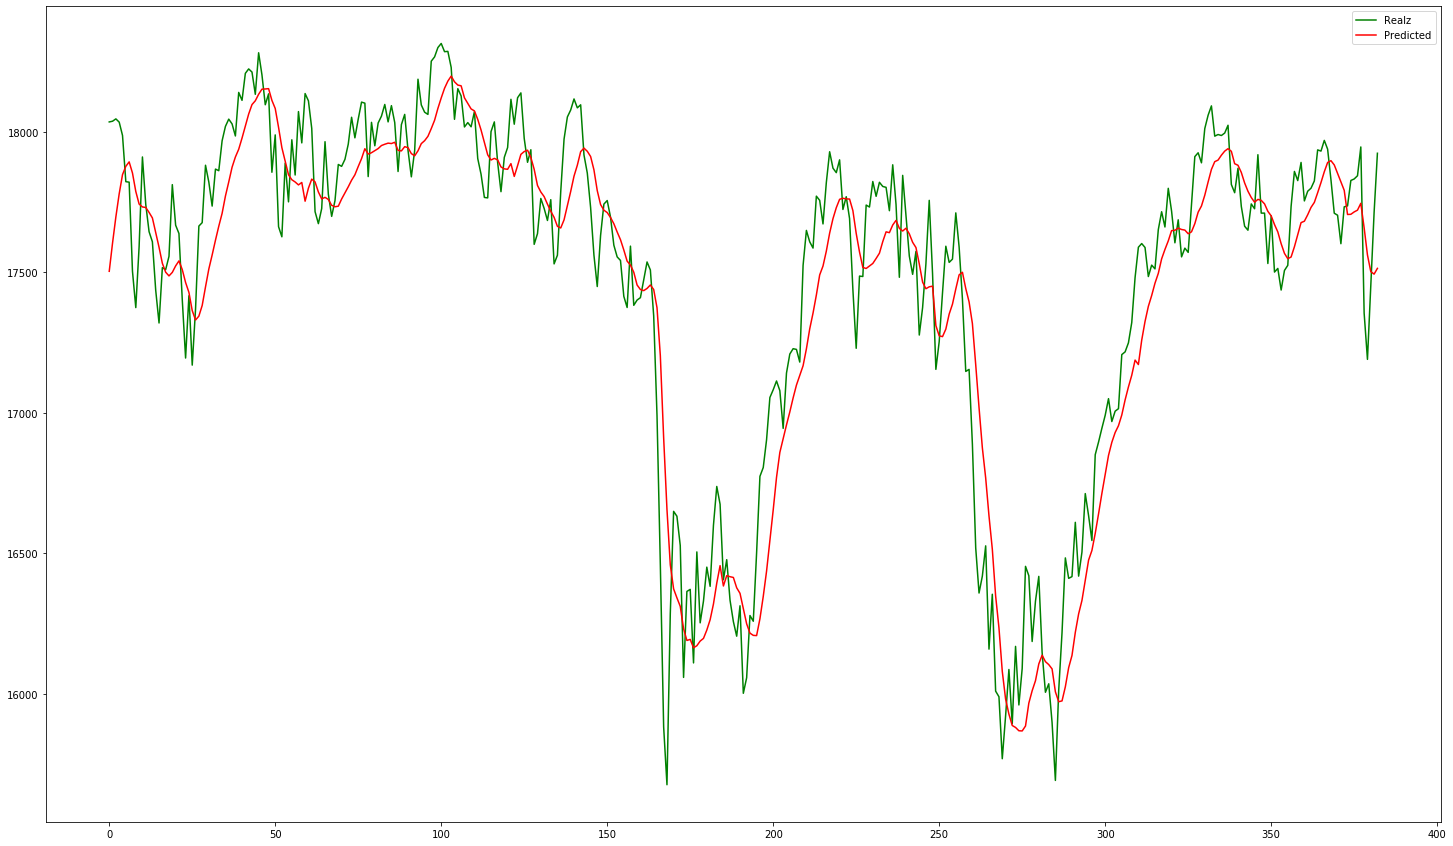

In [10]:
#get current figure
plt.gcf().set_size_inches(25, 15, forward=True)
plt.plot(unscaled_y_test, label="Real", color="green")
plt.plot(y_test_predicted, label="Prediction", color="red")
plt.legend(["Realz", "Predicted"])
plt.show()

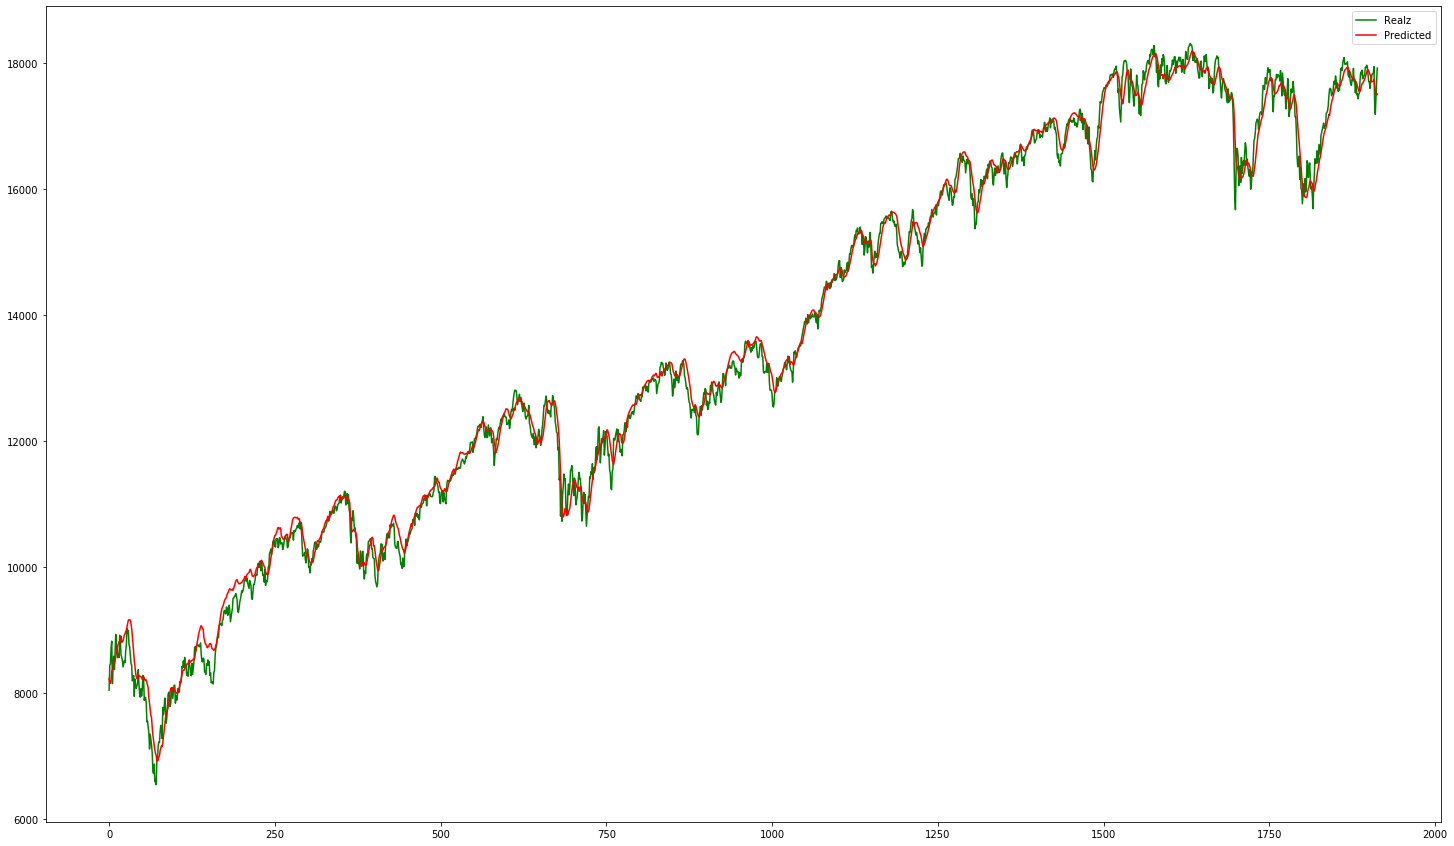

In [11]:
plt.gcf().set_size_inches(25, 15, forward=True)
plt.plot(unscaled_y, label="Real", color="green")
plt.plot(y_predicted, label="Prediction", color="red")
plt.legend(["Realz", "Predicted"])
plt.show()